In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib


# matplotlib.rcParams['axis=none']

In [48]:
matplotlib.rcParams['figure.figsize'] = [8,8]

In [267]:
# def crop_mask(im, y):
#         ny, nx = im.shape
#         y,x = np.mgrid[0:nx,0:ny]
#         r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
#         return ( (r < rcirc))

def detect_line_segments(cropped_edges):
    # tuning min_threshold, minLineLength, maxLineGap is a trial and error process by hand
    rho = 5  # distance precision in pixel, i.e. 1 pixel
    angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
    min_threshold = 5  # minimal of votes
    line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                    np.array([]), minLineLength=8, maxLineGap=4)

    return line_segments

def make_points(frame, line):
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        # logging.info('No line_segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1/3
    left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                # logging.info('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))

    # logging.debug('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return lane_lines


def display_lines(frame, lines, line_color=(0, 255, 0), line_width=2):
    line_image = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
    line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    return line_image



    

In [268]:
def mask_color(frame, color, min_edge_threshold=100, max_edge_threshold=200):

    white = [[220,220,220],[255,255,255]]
    # orange = [[14, 25, 85], [23, 100, 100]]
    orange = [[210, 140, 100], [240, 200, 180]]

    if color=='white':

        lower = np.array(white[0])
        upper = np.array(white[1])

    elif color=='orange':
        lower = np.array(orange[0])
        upper = np.array(orange[1])

    mask = cv2.inRange(frame, lower ,upper)
    output = cv2.bitwise_and(frame, frame, mask = mask)

    edges = cv2.Canny(output, min_edge_threshold, max_edge_threshold)
    return output, edges
    # cv2.imwrite('images.jpg', output)



def comparison_plot(frame_1, frame_2):
    plt.figure(figsize=(12,12))
    
    plt.subplot(121)
    im1 = plt.imshow(frame_1)
    plt.title('Frame 1')
    plt.axis('off')
    plt.subplot(122)
    im2 = plt.imshow(frame_2)
    plt.title('Frame 2')
    plt.axis('off')
    plt.show()


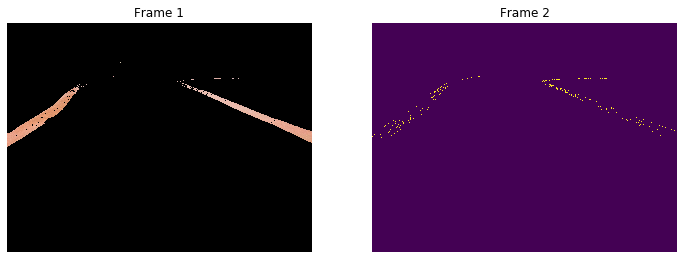

In [269]:
img_bgr = cv2.imread('straight_80.jpg')
# img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.savefig('image_hsv.jpg')
output, edges = mask_color(img, color='orange', min_edge_threshold=110, max_edge_threshold=210)
comparison_plot(output, edges)
# comparison_plot(img, output)

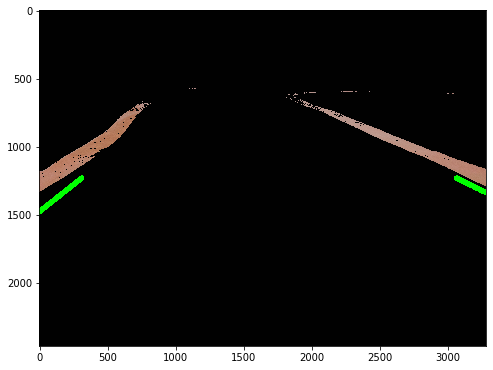

In [270]:
lane = detect_line_segments(edges)

lines = average_slope_intercept(img,lane)

lane_lines = display_lines(output, lines, line_width=40)
plt.imshow(lane_lines)